In [2]:
#LBL1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import cv2

In [3]:
#LBL2

def explore_dataset(file_path):
    # Загрузка данных
    data = np.load(file_path)
    images = data['data']  # Извлечение изображений
    labels = data['labels']  # Извлечение меток

    print(f"Файл: {file_path}")
    print(f"Количество изображений: {images.shape[0]}")
    print(f"Размер каждого изображения: {images[0].shape}")
    print(f"Количество меток: {len(labels)}")
    print(f"Пример меток: {np.unique(labels)}")

    # Визуализация нескольких изображений
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Покажем первые 9 изображений
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Файл: train.npz
Количество изображений: 18000
Размер каждого изображения: (224, 224, 3)
Количество меток: 18000
Пример меток: [0 1 2 3 4 5 6 7 8]


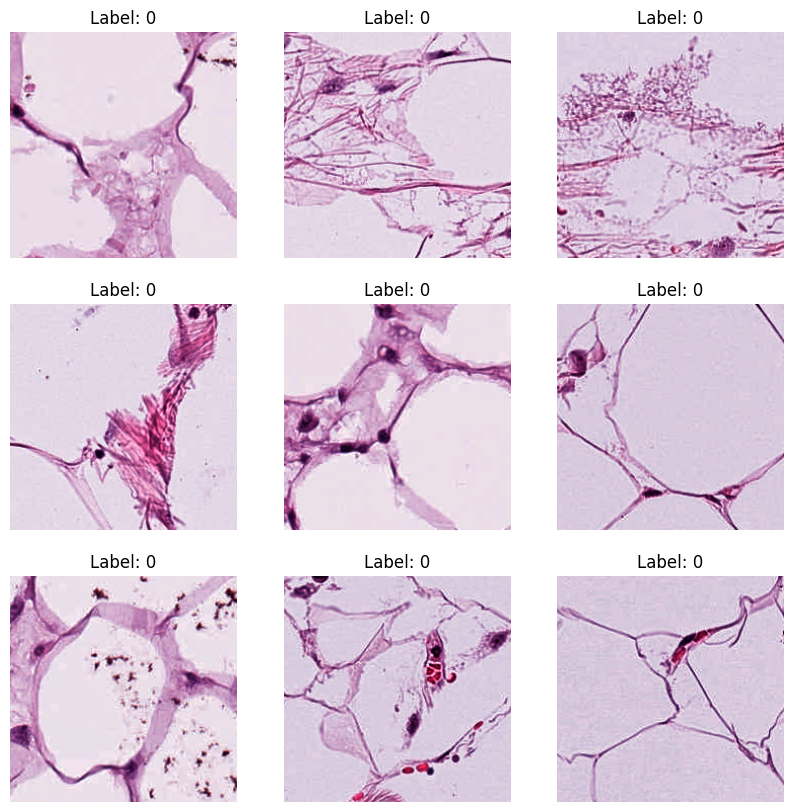

Файл: test.npz
Количество изображений: 4500
Размер каждого изображения: (224, 224, 3)
Количество меток: 4500
Пример меток: [0 1 2 3 4 5 6 7 8]


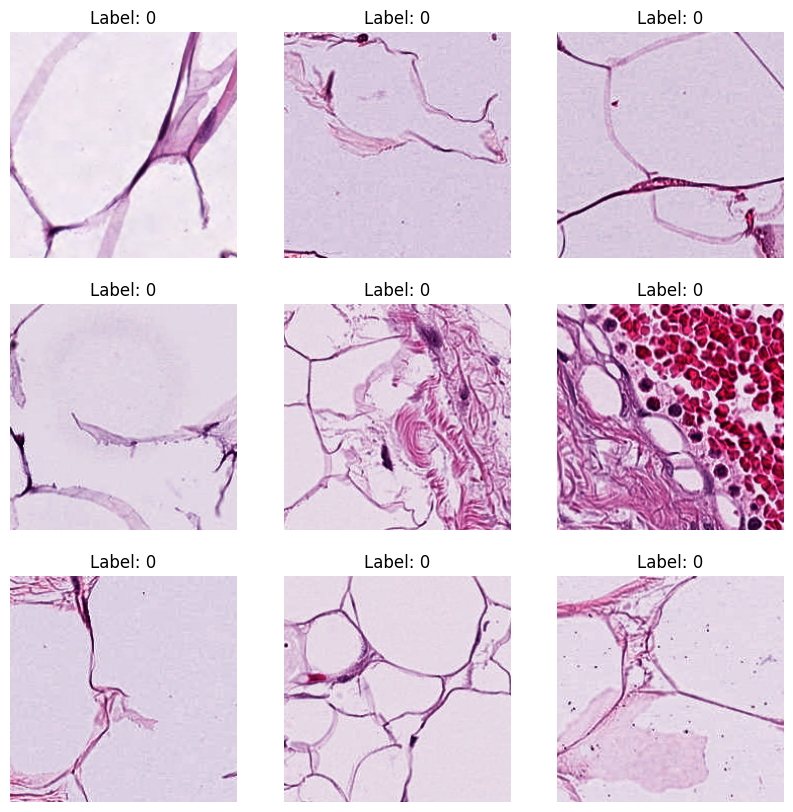

In [4]:
# Просмотр train и test данных
explore_dataset('train.npz')  #LBL2
explore_dataset('test.npz')  #LBL2


In [5]:
#LBL3

class Dataset:
    def __init__(self, name, resize_to=(64, 64)):  # Размер 64x64
        self.name = name
        self.is_loaded = False
        output = f'{name}.npz'
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(output)
        resized_images = [cv2.resize(img, resize_to) for img in np_obj['data']]
        self.images = np.array(resized_images, dtype=np.float32) / 255.0
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {self.name} consists of {self.n_files} images with size {resize_to}.')

    def get_data_and_labels(self):
        return self.images, to_categorical(self.labels, num_classes=9)


In [6]:
#LBL4

class CNNModel:
    def __init__(self):
        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Входное изображение 64x64
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(9, activation='softmax')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=64):  # Батч 64
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
        lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

        print("Начало обучения модели CNN...")
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, lr_reduction])
        print("Обучение завершено.")
        return history

    def save(self, name: str):
        self.model.save(f'{name}.h5')
        print(f'Model saved at: {name}.h5')

    def load(self, name: str):
        self.model = tf.keras.models.load_model(f'{name}.h5')
        print(f'Model loaded from: {name}.h5')

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_accuracy:.4f}')
        return test_accuracy

In [7]:
#LBL5
d_train = Dataset('train')
d_test = Dataset('test')

X_train, y_train = d_train.get_data_and_labels()
X_test, y_test = d_test.get_data_and_labels()

#LBL6
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#LBL7
model = CNNModel()
history = model.train(X_train_split, y_train_split, X_val, y_val, epochs=20, batch_size=64)

#LBL8
model.save('cnn_model')

#LBL9
test_accuracy = model.evaluate(X_test, y_test)


Loading dataset train from npz.
Done. Dataset train consists of 18000 images with size (64, 64).
Loading dataset test from npz.
Done. Dataset test consists of 4500 images with size (64, 64).


/home/fantom/jupyter_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-02 23:51:39.196954: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Начало обучения модели CNN...
Epoch 1/20


2024-12-02 23:51:39.478198: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 707788800 exceeds 10% of free system memory.


225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 291ms/step - accuracy: 0.4280 - loss: 1.9289 - val_accuracy: 0.1147 - val_loss: 8.3743 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - accuracy: 0.6386 - loss: 0.9795 - val_accuracy: 0.2528 - val_loss: 3.7920 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 298ms/step - accuracy: 0.7138 - loss: 0.7905 - val_accuracy: 0.6969 - val_loss: 0.8527 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 314ms/step - accuracy: 0.7615 - loss: 0.6607 - val_accuracy: 0.7397 - val_loss: 0.7220 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 280ms/step - accuracy: 0.7969 - loss: 0.5547 - val_accuracy: 0.6944 - val_loss: 0.9458 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 62s 275ms/step - accuracy: 0.8368 - loss: 0.4757 - val_accuracy: 0.7608 - val_loss: 0.7455 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 294ms/step - 

Обучение завершено.
Model saved at: cnn_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9101 - loss: 0.2743
Test Accuracy: 0.8591


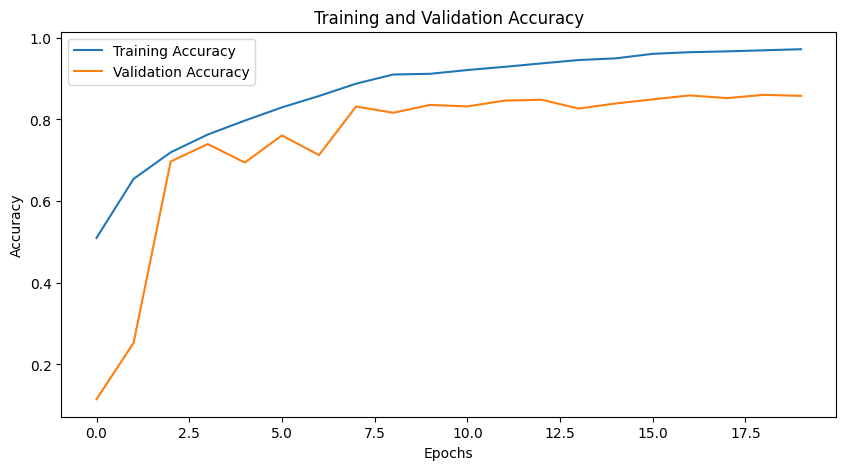

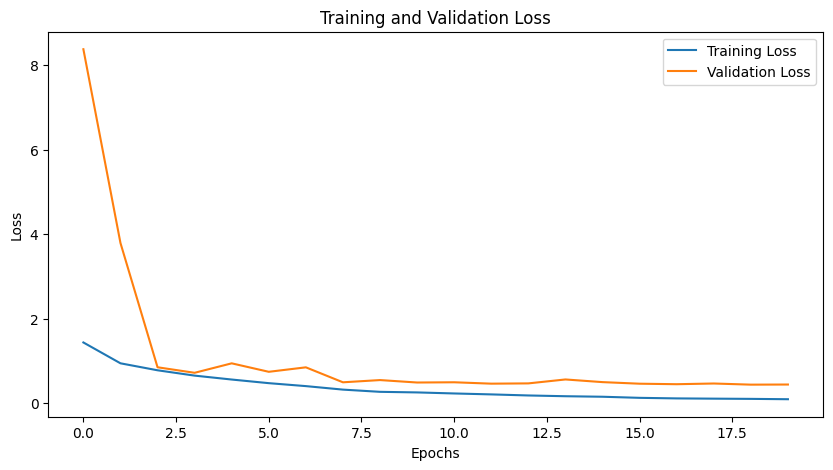

In [8]:
#LBL10
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()